# Выбор локации для скважины

Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

## Загрузка и подготовка данных

### Для начала откроем все необходимые библиотеки

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler 
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats as st
import seaborn as sns
import warnings

### Запишем константны

In [2]:
RANDOM_STATE = 10000
bar_price = 450000
budget = 10e9
count_well = 200
state = np.random.RandomState(RANDOM_STATE)
blue = '#069af3'
green = '#7eb54e'
red = '#ef4026'

- bar_price - цена за 1000 баррелей
- budget - общий бюджет на разработку скважин
- count_well - количество скважин
- red, green, blue - цвета для будующих графиков

### Теперь откроем и посмотрим файлы

In [3]:
data_0 = pd.read_csv('/datasets/geo_data_0.csv')
data_1 = pd.read_csv('/datasets/geo_data_1.csv')
data_2 = pd.read_csv('/datasets/geo_data_2.csv')

In [4]:
data_0.info()
data_0.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


<AxesSubplot:>

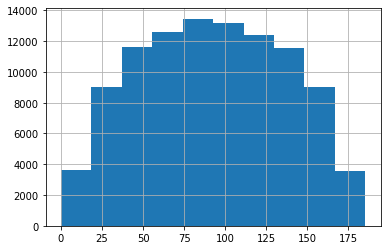

In [5]:
data_0['product'].hist()

In [6]:
data_1.info()
data_1.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


<AxesSubplot:>

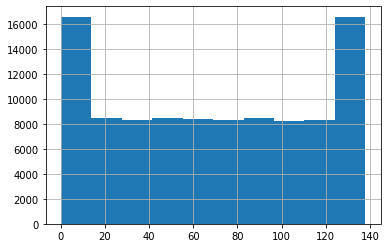

In [7]:
data_1['product'].hist()

In [8]:
data_2.info()
data_2.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


<AxesSubplot:>

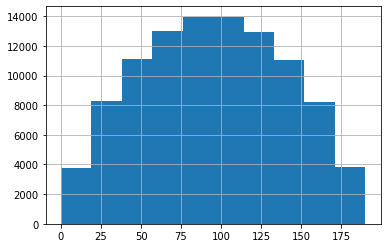

In [9]:
data_2['product'].hist()

Никаких пропусков в данных нет. Судя по гистограммам, у первого и третьего региона нормально распределение сырья, большинство значений примерно в середине, а вот у второго пики на самых маленьких и больших значениях, однако и наибольшие значения меньше остальных. Нужны дальнейшие расчёты

### Проверим дубликаты в данных по id

In [10]:
print('Дубликаты в первом регионе', data_0['id'].duplicated().sum())
print('Дубликаты во втором регионе', data_1['id'].duplicated().sum())
print('Дубликаты в третьем регионе', data_2['id'].duplicated().sum())

Дубликаты в первом регионе 10
Дубликаты во втором регионе 4
Дубликаты в третьем регионе 4


Повторяющиеся элементы действительно есть, однако их очень мало, 10 значений на 100000 строк

### Посмотрим на корреляцию

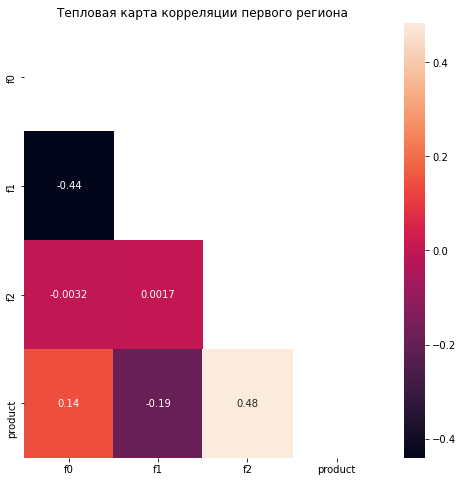

In [11]:
fig, ax = plt.subplots(figsize=(8, 8))
sns.heatmap(data_0.corr(), 
            annot = True, 
            mask=np.triu(data_0.corr())).set_title('Тепловая карта корреляции первого региона')
plt.show()

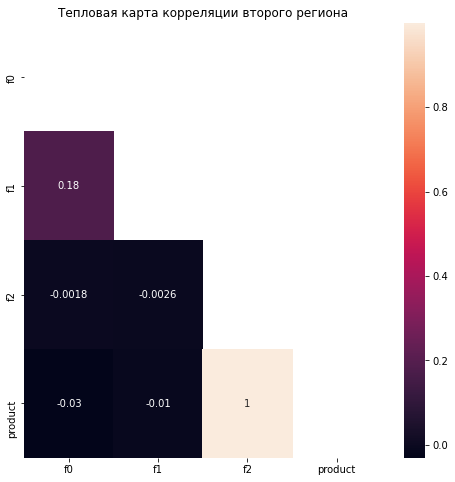

In [12]:
fig, ax = plt.subplots(figsize=(8, 8))
sns.heatmap(data_1.corr(), 
            annot = True, 
            mask=np.triu(data_1.corr())).set_title('Тепловая карта корреляции второго региона')
plt.show()

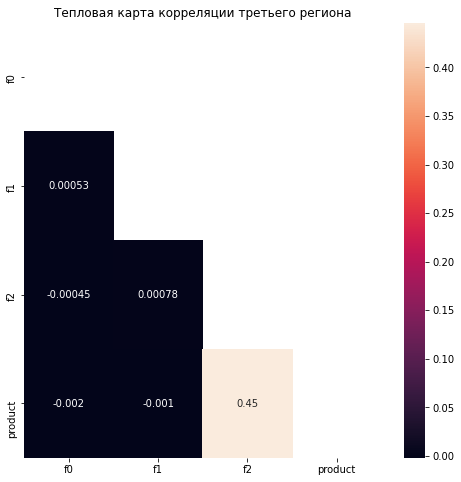

In [13]:
fig, ax = plt.subplots(figsize=(8, 8))
sns.heatmap(data_2.corr(), 
            annot = True, 
            mask=np.triu(data_2.corr())).set_title('Тепловая карта корреляции третьего региона')
plt.show()

Корреляция есть, в целом так и должно быть, ведь пробы делают не просто так, однако у второго и третьего региона корреляция по большому счёту есть только от третьей пробы, первая и вторая как будто ни на что не влияют. Возможно она самая точная из всех, а может и нет

### Подготовим данные для обучения

In [14]:
target_0 = data_0['product']
features_0 = data_0.drop(['product', 'id'], axis=1)
target_1 = data_1['product']
features_1 = data_1.drop(['product', 'id'], axis=1)
target_2 = data_2['product']
features_2 = data_2.drop(['product', 'id'], axis=1)

In [15]:
features_train_0, features_valid_0, target_train_0, target_valid_0 = train_test_split(
    features_0, target_0, test_size=0.25, random_state=RANDOM_STATE)
features_train_1, features_valid_1, target_train_1, target_valid_1 = train_test_split(
    features_1, target_1, test_size=0.25, random_state=RANDOM_STATE)
features_train_2, features_valid_2, target_train_2, target_valid_2 = train_test_split(
    features_2, target_2, test_size=0.25, random_state=RANDOM_STATE)

## Обучение и проверка модели

По условиям задачи подходит только линейная регрессия, значит именно её мы и будем использовать

### Модель и вычисления для первого региона

In [16]:
model = LinearRegression()
model.fit(features_train_0, target_train_0)
predictions_valid_0 = model.predict(features_valid_0)
result_0 = mean_squared_error(target_valid_0, predictions_valid_0) ** 0.5
print("RMSE модели на валидационной выборке:", result_0)
print('Средний запас предсказанного сырья', sum(predictions_valid_0) / len(predictions_valid_0))

RMSE модели на валидационной выборке: 37.71000259560676
Средний запас предсказанного сырья 92.41387752778155


У первого региона давольно большие запасы в среднем, однако предсказания получаются достаточно неточными, что может привести к ненужным рискам, но это нужно будет проверить

### Модель и вычисления для второго региона

In [17]:
model = LinearRegression()
model.fit(features_train_1, target_train_1)
predictions_valid_1 = model.predict(features_valid_1)
result_1 = mean_squared_error(target_valid_1, predictions_valid_1) ** 0.5
print("RMSE модели на валидационной выборке:", result_1)
print('Средний запас предсказанного сырья', sum(predictions_valid_1) / len(predictions_valid_1))

RMSE модели на валидационной выборке: 0.8939620215349734
Средний запас предсказанного сырья 68.42645858331633


Для второго региона получились достаточно точные предсказания, однако в среднем запасы не такие большие, хотя по гистограмме выше этот регион может подойти, ведь там достаточно много скважин с большим значениями сырья

### Модель и вычисления для третьего региона

In [18]:
model = LinearRegression()
model.fit(features_train_2, target_train_2)
predictions_valid_2 = model.predict(features_valid_2)
result_2 = mean_squared_error(target_valid_2, predictions_valid_2) ** 0.5
print("RMSE модели на валидационной выборке:", result_2)
print('Средний запас предсказанного сырья', sum(predictions_valid_1) / len(predictions_valid_1))

RMSE модели на валидационной выборке: 40.17098452637588
Средний запас предсказанного сырья 68.42645858331633


К сожалению, третий регион собрал худшие качества предыдущих, в среднем модель сильно ошибается и не высокий средний запас сырья

### Теперь необходимо собрать все данные воедино

In [19]:
warnings.filterwarnings("ignore")
predict_data_0 = features_valid_0.copy()
predict_data_0['id'] = data_0['id']
predict_data_0['product'] = target_valid_0
predict_data_0['predict_product'] = predictions_valid_0
predict_data_0.head()

,f0,f1,f2,id,product,predict_product
84874,1.030106,-0.548676,6.661980,O2lBA,126.082568,133.276294
22363,-0.950916,0.290856,2.688060,0iTow,124.404614,87.770241
73364,1.000412,0.186644,1.427121,Kh87w,64.834947,88.244531
67585,0.594620,-0.384555,-0.867419,65HyG,109.296102,79.776735
39535,0.625846,-0.526510,2.295709,b1IAI,113.110669,102.726433


In [20]:
data_0[data_0['id'] == 'O2lBA']

,id,f0,f1,f2,product
84874,O2lBA,1.030106,-0.548676,6.66198,126.082568


Для проверки возьмём тот же id из изначальной таблицы. Все данные сходяться, хоть и возникает ошибка

In [21]:
warnings.filterwarnings("ignore")
predict_data_1 = features_valid_1.copy()
predict_data_1['id'] = data_1['id']
predict_data_1['product'] = target_valid_1
predict_data_1['predict_product'] = predictions_valid_1
predict_data_1.head()

,f0,f1,f2,id,product,predict_product
84874,1.637149,-14.791995,0.998364,Ghosm,26.953261,28.641199
22363,4.482999,-13.458786,4.002484,wcwoE,107.813044,109.167763
73364,16.375786,0.181385,3.999900,Z97qV,107.813044,107.081476
67585,-4.993060,-4.845680,-0.002657,JORCy,3.179103,2.406924
39535,4.712690,-9.209218,3.992220,7888Y,107.813044,108.766140


In [22]:
warnings.filterwarnings("ignore")
predict_data_2 = features_valid_2.copy()
predict_data_2['id'] = data_2['id']
predict_data_2['product'] = target_valid_2
predict_data_2['predict_product'] = predictions_valid_2
predict_data_2.head()

,f0,f1,f2,id,product,predict_product
84874,1.649244,-0.793305,5.448483,fg7t1,106.699768,112.145328
22363,0.249778,2.052321,-0.080079,4IIA7,61.751369,79.884470
73364,1.812267,0.491508,5.112559,YLHZE,100.482754,110.024477
67585,1.348817,-1.535672,3.044722,SwQKq,168.529310,98.353961
39535,-1.255492,1.447630,5.447971,RDORX,126.081641,112.048772


Все данные объеденены, можем перейти к расчётам

## Подготовка к расчёту прибыли

### Расчитаем обём одной скважины для безубыточной разработки

In [23]:
budget / count_well / bar_price

111.11111111111111

В среднем каждая разработанная скважина должна содеожать не менее 111 баррелей нефти. Посмотрим сколько нефти в среднем содержиться в скважинах каждого региона

In [24]:
print('Средний объём скважин в первом регионе' ,predict_data_0['predict_product'].mean())
print('Средний объём скважин во втором регионе' ,predict_data_1['predict_product'].mean())
print('Средний объём скважин в третьем регионе' ,predict_data_2['predict_product'].mean())

Средний объём скважин в первом регионе 92.41387752778085
Средний объём скважин во втором регионе 68.42645858331672
Средний объём скважин в третьем регионе 95.12581551796451


В среднем показатели меньше необходимых, но у нас достаточно много предпологаемых скважин, думаю в каждом регионе можно будет подобрать хорошие результаты

## Расчёт прибыли и рисков 

Напишем функцию для расчётов и посчитаем, сколько прибыли может принести каждый регион

In [25]:
def profit(data):
    top_200 = data['predict_product'].sort_values(ascending=False).head(count_well).sum()
    return top_200 * bar_price - budget

In [26]:
print('прибыль от сырья по регионам без учёта погрешности предсказаний:')
print('Первый регион' ,profit(predict_data_0))
print('Второй регион' ,profit(predict_data_1))
print('Третий регион' ,profit(predict_data_2))

прибыль от сырья по регионам без учёта погрешности предсказаний:
Первый регион 3869409891.621317
Второй регион 2485355748.8315544
Третий регион 3431344601.721609


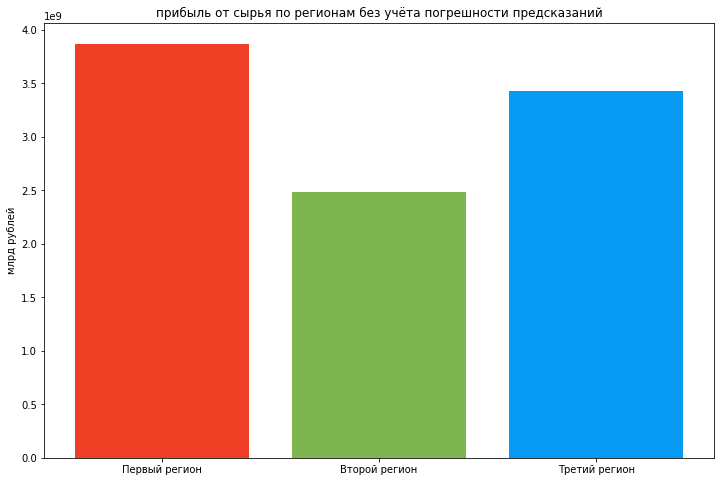

In [27]:
predict_profit = [profit(predict_data_0), profit(predict_data_1), profit(predict_data_2)]
plt.figure(figsize=(12,8))
objects = ('Первый регион', 'Второй регион', 'Третий регион')
y_pos = np.arange(len(objects))
plt.bar(y_pos, predict_profit, align='center', color=[red, green, blue])
plt.xticks(y_pos, objects)
plt.ylabel('млрд рублей')
plt.title('прибыль от сырья по регионам без учёта погрешности предсказаний')
plt.show()

In [28]:
print('минимальная прибыль от сырья по регионам с учётом погрешности предсказаний:')
print('Первый регион' ,profit(predict_data_0) - (result_0 * count_well * bar_price))
print('Второй регион' ,profit(predict_data_1) - (result_1 * count_well * bar_price))
print('Третий регион' ,profit(predict_data_2) - (result_2 * count_well * bar_price))

минимальная прибыль от сырья по регионам с учётом погрешности предсказаний:
Первый регион 475509658.0167084
Второй регион 2404899166.893407
Третий регион -184044005.65222025


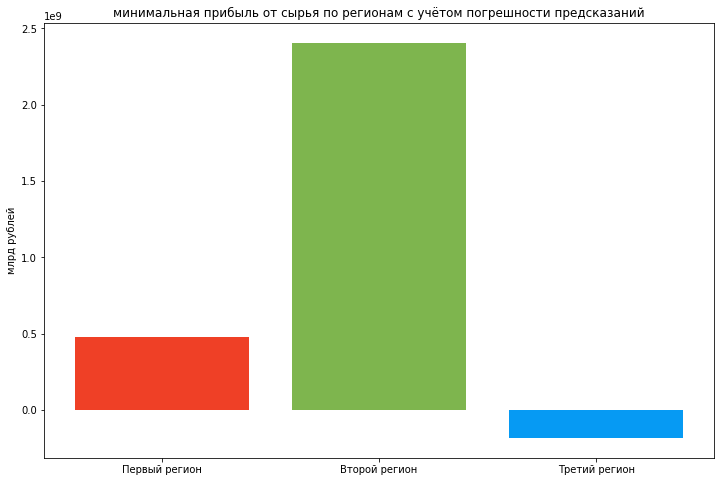

In [29]:
min_predict_profit = [profit(predict_data_0) - (result_0 * count_well * bar_price), 
                      profit(predict_data_1) - (result_1 * count_well * bar_price), 
                      profit(predict_data_2) - (result_2 * count_well * bar_price)]
plt.figure(figsize=(12,8))
y_pos = np.arange(len(objects))
plt.bar(y_pos, min_predict_profit, align='center', color=[red, green, blue])
plt.xticks(y_pos, objects)
plt.ylabel('млрд рублей')
plt.title('минимальная прибыль от сырья по регионам с учётом погрешности предсказаний')
plt.show()

Судя по всем расчётам, если бы модели предсказывали одинаково хорошо, то первый регион самый перспективный, почти 4 млрд прибыли, но вот при худшем расккладе самая большая прибыль будет от второго региона, почти 2.5 млрд. Продолжим расчёты для окончательных выводов

## Риски и прибыль для каждого региона

### Для начала создадим функцию для расчётов

Поскольку по условиям задачи мы должны выбирать 200 лучших точек из 500, именно так и поступим. Для начала выберем 500 точек из всей выборки, после чего отберём 200 лучших из них. Точки берём без повторений, поскольку в реальной жизни будет странно брать одну и ту же скважину несколько раз 

In [30]:
def revenue(target, predict_data, count):
    probs_sorted = predict_data.sort_values(ascending=False)
    selected = target[probs_sorted.index][:count]
    return bar_price * selected.sum() - budget

In [31]:
predict_data_all = [predict_data_0, predict_data_1, predict_data_2]
mean_profit = []
loss_probability = []
for n in range(len(predict_data_all)):
    values = []
    for i in range(1000):
        target_subsample = predict_data_all[n]['product'].sample(500, replace=True, random_state=state)
        probs_subsample = predict_data_all[n]['predict_product'][target_subsample.index] 
        subsample = revenue(target_subsample, probs_subsample, 200)
        values.append(subsample)
    values = pd.Series(values)
    mean_profit.append(values.mean())
    loss_probability.append(values[values < 0].count() / len(values) * 100)
    print(objects[n])
    print('95%-ый доверительный интервал:',values.quantile(0.025), values.quantile(0.975))
    print('Cреднее:' ,values.mean())
    print('вероятность получить убыток в процентах' ,values[values < 0].count() / len(values) * 100)

Первый регион
95%-ый доверительный интервал: -70874068.8509178 980507592.5298747
Cреднее: 449712137.089698
вероятность получить убыток в процентах 4.8
Второй регион
95%-ый доверительный интервал: 71690877.81218405 897962791.3478662
Cреднее: 503558003.3338932
вероятность получить убыток в процентах 1.4000000000000001
Третий регион
95%-ый доверительный интервал: -230798829.62491786 868372572.2281072
Cреднее: 321735032.612062
вероятность получить убыток в процентах 12.6


Все данные посчитаны, к сожалению, хоть у второго региона и самая большая средняя прибыль, есть достаточно большая вероятность, что прибыль с региона в целом не удасться получить, получиться лишь уйти в убыток, это не очень хорошо

### Посмотрим на данные по графикам

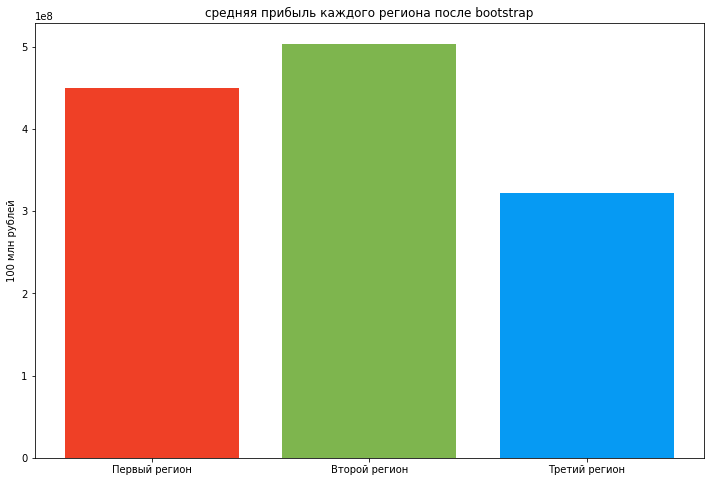

In [32]:
plt.figure(figsize=(12,8))
y_pos = np.arange(len(objects))
plt.bar(y_pos, mean_profit, align='center', color=[red, green, blue])
plt.xticks(y_pos, objects)
plt.ylabel('100 млн рублей')
plt.title('средняя прибыль каждого региона после bootstrap')
plt.show()

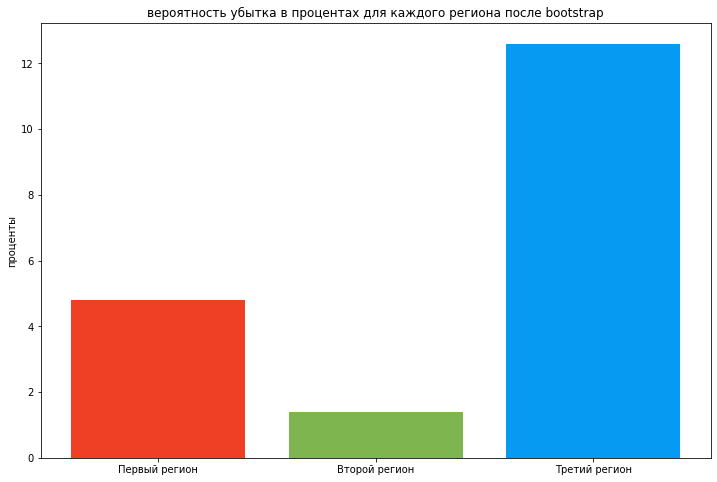

In [33]:
plt.figure(figsize=(12,8))
y_pos = np.arange(len(objects))
plt.bar(y_pos, loss_probability, align='center', color=[red, green, blue])
plt.xticks(y_pos, objects)
plt.ylabel('проценты')
plt.title('вероятность убытка в процентах для каждого региона после bootstrap')
plt.show()

## Вывод

```
Для разработки скважин предлагаю выбрать второй регион, поскольку, у него и самая большая вероятная средняя прибыль, а так же самая низкая вероятности принести убытки компании, всего 1.6% вероятности убытка. При этом средний показатель прибыли равен 467 млн рублей, что больше и превого и третьего регионов. В целом от региона можно получить от 453 до 948 млн рублей прибыли, с сравнительно низкой веростностью уйти в убыток, потому предлагаю остановиться именно на нём.
```